# Estimating errors between two trajectories

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import validator as validator
import doctest

## Useful functions
### How to test a solution?

In [20]:
def solution(X, Y):
    return np.abs(np.trapz(*X.transpose()[::-1]) - np.trapz(*Y.transpose()[::-1]))

In [21]:
np.loadtxt("test/[test0]simple.txt", skiprows=0, max_rows=2, unpack=True, delimiter=',')

array([[0., 0.],
       [1., 0.],
       [2., 1.],
       [3., 1.],
       [4., 0.]])

In [22]:
validator.test(solution, display = False, samples_range = slice(0, 5))

[test0]simple.txt	

TypeError: iteration over a 0-d array

### Distance between two points

In [46]:
def dist(P, Q):
    """
    >>> dist(*np.array([[-8, 9],[0, 0]]))
    12.041594578792296
    >>> dist(np.array([10, 20]), np.array([-4, 5]))
    20.518284528683193
    >>> dist(np.array([-3, 5]), np.array([-3, 5]))
    0.0
    """
    return np.sqrt(np.sum((P-Q)**2 ))

def dist_to_line(A1, A2, B):
    """ distance from B to line (A1A2)"""
    # equation of the line (A1A2) is defined as by = ax + c
    b, a = A2 - A1
    c = b*A1[1] - a*A1[0]
    return abs(b*B[1] - a*B[0] - c)/np.hypot(a, b)

# def slope(A, B):
#     """ returns slope of the line (AB) """
#     return (B[1] - A[1]) / (B[0] - A[0])

def orientation(A, B, C):
    """ Return 1 if Counterclockwise (and colinear)??, -1 if clockwise """
    r = (B[1] - A[1]) * (C[0] - B[0]) - (C[1] - B[1]) * (B[0] - A[0])
    if np.abs(r) < 1e-5 : # r = 0
        return 0
    elif r > 0:
        return 1
    else:
        return -1
    
if __name__ == "__main__":
    doctest.testmod()

### Finding the intersection point of two line segments
Let $p_1$ and $p_2$ be the (2D) endpoints of one segment and let $q_1$ and $q_2$ be the endpoints of the other. A parametrization of these lines are defined as:
$$
\left\{\begin{array}{l}{p_{1}+t_p\left(p_{2}-p_{1}\right)} \\ {p_{3}+t_q\left(p_{4}-p_{3}\right)}\end{array}\right.
$$
where $t_p, t_q \in [0,1]$. Thus, the segments intersect iff there exists $(s,t)$ such that:
$$p_1+t_p(p_2-p_1) = q_1+t_q(q_2-q_1)$$
i.e.
$$t_q(q_2-q_1) + t_p(p_1-p_2) = p_1 - q_1$$
We can define our system using matrices ($p_1$, $p_2$, $q_1$, $q_2$ being a column vector of size 2) :
$$
\underbrace{\left[
    \begin{array}{ll}
        q_2-q_1 & p_1-p_1\end{array}
\right]}_A \times 
\underbrace{\left[
    \begin{array}{l}
        t_q \\ t_p\end{array}
\right]}_T = 
\underbrace{\left[
    \begin{array}{ll}
        p_1 & q_1\end{array}
\right]}_B
$$
* if a solution $(t_p, t_q)$ exists and is in $[0,1]\times[0,1]$, the segments intersect (at $p_{1}+t_p(p_{2}-p_{1})$).
* if A is not inversible, the segments have the same slope (we need to test if segments are colinear or parallel)

In [23]:
def find_intersection_seg(p1, p2, q1, q2, display = False):
    """ Find intersection point between [p1, p2] and [q1, q2] 
    Parameters :
        - p1, p2, q1, q2 : np.ndarrays of shape (2,)
    Returns : the coordinates of the intersection points,  
        if the line segments intersect
    
    [TODO] Manage the case where the matrix is singular
    
    >>> find_intersection_seg(*np.array([[10, 5], [8, 1], [3,7],[0,1]]))
    array([inf, inf])
    """
    
    
    
    a = np.array([q2-q1, p1-p2]).transpose()
    if display:
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-o')
        plt.plot([q1[0], q2[0]], [q1[1], q2[1]], '-o')
    if np.linalg.det(a): # if a is invertible (if lines intersect)
        b = p1 - q1
        t = np.linalg.solve(a,b)
        if np.all(0 < t) and np.all(t < 1): # segments intersect
            intersection = p1 + t[1]*(p2-p1)
            if display:
                plt.plot(*(intersection), 'o')
            return intersection 
    return np.array([np.inf, np.inf])

if __name__=="__main__":
        doctest.testmod()

### Finding the intersection point of two lines

In [24]:
def norm(X):
    return (np.sum(X*X))**(0.5)

def is_colinear(v1, v2):
    return abs(np.dot(v1, v2)) == norm(v1) * norm(v2)

def find_eq_line(A, B):
    """ax + by = c"""
    a = B[1] - A[1]
    b = A[0] - B[0]
    c = b*A[1] + a*A[0]
    return a, b, c

def find_intersection_lines(p1, p2, q1, q2):
    a1, b1, c1 = find_eq_line(p1, p2)
    a2, b2, c2 = find_eq_line(q1, q2)
    denom = a1*b2 - a2*b1
    xs = (c1*b2 - c2*b1) / denom if denom else np.inf
    ys = (a1*c2 - a2*c1) / denom if denom else np.inf
    return np.array([xs, ys])

def find_intersection_line_seg(p1, p2, q1, q2):
    """intersection between (p1, p2) and ]q1, q2["""
    s = find_intersection_lines(p1, p2, q1, q2)
    # we have two find whether or not s belongs to ]q1, q2]
    ks = np.dot(q2-q1, s-q1)
    kp = np.dot(q2-q1, q2-q1)
    if 0 < ks < kp:
        return s
    elif ks >= kp:
        return np.inf
    else: # ks <= 0
        return -np.inf

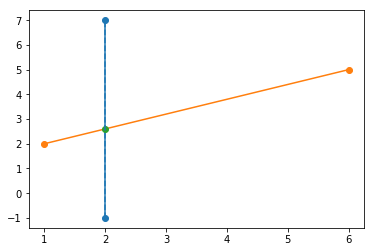

In [25]:
# Testing fing_intersection_line_seg
set = np.array([[2, 7], [2,-1], [6,5], [1,2]])
plt.plot(set[:2,0], set[:2,1], '-o')
plt.plot(set[2:,0], set[2:,1], '-o')
plt.plot(*find_intersection_line_seg(*set), 'o')
a, b, c = find_eq_line(*set[:2])
if b:
    x = np.linspace(np.min(set, axis = 0)[0], np.max(set, axis = 0)[0], 200)
    plt.plot(x, (c - a*x)/b, 'C0--')
else:
    plt.plot([c/a, c/a], [np.min(set, axis = 0)[1], np.max(set, axis = 0)[1]], 'C0--')

### Suite ..

In [26]:
# coder intersections

---
## Solution 1 - Bases triangulaires

In [27]:
# T # trajectory , two colums matrix 
# P # path follown, two colums matrix

#lgT=len(T), lgP=len(P),depMin=min (T[0][0], P[0][0]),endMin=min (T[lgT][0], P[LgP][0])


# interval  of  computing is [depmin, endMin]

# determination of the intervall lenght for calculation

def lengI(T,P):
    d1=0
    d2=0
    for i in range (len(P[:, 0])+1):
        if len(P[:, 0])>d1:
            d1=P[:, 0][i]
    for i in range (len(T[:, 0])+1):
        if T[:, 0][i]>d2:
            d2=T[:, 0][i]
    return min (d1,d2)
T=np.array([[0,0],[1,0],[2,1],[3,1],[4,0]])
P=np.array([[0,3],[1,3],[2,2],[3,2],[4,5]])

lengI(T,P)


IndexError: index 5 is out of bounds for axis 0 with size 5

In [10]:
T=np.array([[0,0],[1,0],[2,1],[3,1],[4,0]])
P=np.array([[0,3],[1,3],[2,2],[3,2],[4,5]])
len(P[:, 0])
d1=0
for i in range len(P[:, 0]):
        if P[:, 0][i]>d1:
            d1=P[:, 0][i]



SyntaxError: invalid syntax (<ipython-input-10-b0f2daa9d8ba>, line 5)

---
## Solution 2 - Pivots

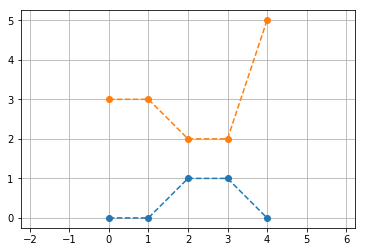

In [11]:
from matplotlib.patches import Polygon
from matplotlib.ticker import MaxNLocator

testname = "test/[test0]simple.txt"
X = np.loadtxt(testname, skiprows=0, max_rows=2, unpack=True, delimiter=',')
Y = np.loadtxt(testname, skiprows=2, max_rows=2, unpack=True, delimiter=',')

plt.figure()
plt.plot(*X.transpose(), '--o', *Y.transpose(), '--o')
plt.axis("equal")
plt.grid()
plt.show()

In [ ]:
def find_next_focus_point1(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to the two current points (p1 or q1)
    Returns: True if p2 is the next focus point, False if q2
    """
    return min(dist(p2, p1), dist(p2, q1)) < min(dist(q2, p1), dist(q2, q1)) #p2 is the closest point

def find_next_focus_point2(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to its respective point (p1 or q1)
    """
    return dist(p2, p1) < dist(q2, q1) #p2 is the closest point
    
def find_next_focus_point3(p1, p2, q1, q2):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)


def find_next_focus_point4(p1, p2, q1, q2, oldpoint):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    wrong_side = orientation(p1, q1, oldpoint)
    if orientation(p1, q1, p2) == wrong_side:
        return False
    elif orientation(p1, q1, q2) == wrong_side:
        return True
    else:
        return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)

In [28]:
NTRIANGLE = 0
def triangle_area(A, B, C, ax):
    global NTRIANGLE
    NTRIANGLE += 1
    ax.add_patch(Polygon([A, B, C], facecolor=["grey", "lightgrey"][NTRIANGLE % 2], ec = "black", alpha = 0.3))
    return 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))

We are defining `si` and `tj` instead of simply using `S[i]` and `T[j]`, in order to be capable of redefining these points in the case of intersection.

In [29]:
def error_btw_trajectories(S, T):
    i, j = 0, 0 # i (or j) is the index of the current point along S (or T)
    si, tj = S[i], T[j]
    plt.figure()
    plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid()
    error, old_point, dir_point = 0, si, (si + tj) / 2
    while i < len(S) - 1 and j < len(T) - 1:
#         plt.show()
#         plt.figure()
#         plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
#         ax = plt.gca()
#         ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#         ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
#         print(i, j, si, S[i+1], tj, T[j+1])
        # 1. Check whether or not there is an intersection between the two next segments
        intersect = find_intersection_seg(si, S[i+1], tj, T[j+1])
        if np.all(intersect != None): # if the segments [S_i, S_i+1] and [T_i, T_i+1] intersect
#             print(">> Intersection")
            # Compute area of the triangle intersect, si, tj
            error += triangle_area(si, tj, intersect, ax)
            plt.plot(*intersect, 'og')
            if find_next_focus_point3(si, S[i+1], tj, T[j+1]):
                old_point = si
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                si, i = S[i+1], i+1
                tj = intersect
            else:
                old_point = tj
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                tj, j = T[j+1], j+1
                si = intersect
        # If there is no intersection, we have to check the orientation of the two next points
        else:
            orientation_s, orientation_t = orientation(si, tj, S[i+1]), orientation(si, tj, T[j+1])
#             print("orientation", orientation_s, orientation_t)
            if orientation_s == 0 and orientation_t == 0:
#                 print("Strange ...")
                if find_next_focus_point3(si, S[i+1], tj, T[j+1]):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            elif orientation_s == orientation_t or orientation_s == 0 or orientation_t==0:
#                 print("old point", old_point, "dir_point", dir_point)
                #simple case : S[i+1] and T[j+1] are on the side of the line (si, tj)
                if orientation_s == 0 or find_next_focus_point4(si, S[i+1], tj, T[j+1], dir_point):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            else : #one point is on the "wrong" side of the line 
#                 print(">> chgt d'angle")
                wrong_side = orientation(si, tj, dir_point) # TODO consider the case when oldpoint==si==tj
                if wrong_side == 0:
                    print("TODO ...")
                    input()
                elif orientation_s == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of T
                    intersect = find_intersection_line_seg(si, S[i+1], tj, T[j+1])
                    if np.all(intersect == np.inf):
                        old_point = tj
                        tj, j = T[j+1], j+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo A")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                        input()
                    else:
                        old_point, tj = tj, intersect
#                         tj = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        si, i = S[i+1], i+1 #TODO deplacer directement le pivot si
                        old_point = si
                elif orientation_t == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of S
                    intersect = find_intersection_line_seg(tj, T[j+1], si, S[i+1])
                    if np.all(intersect == np.inf):
                        old_point = si
                        si, i = S[i+1], i+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo B")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side, old_point)
                        input()
                    else:
                        old_point, si = si, intersect
#                         si = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        tj, j = T[j+1], j+1
                        old_point = tj
                else:
                    print("There is a problem ?")
                    print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                    input()

            # Compute area of the triangle old_point, si, tj
            error += triangle_area(old_point, si, tj, ax)
#         plt.plot(*si, 'rx')
#         plt.plot(*tj, 'rx')
#         plt.plot(*old_point, 'kx')
#         plt.plot(*dir_point, 'cx')
    
    if i == len(S) - 1:
        error += triangle_area(si, tj, T[j+1], ax)
        j += 1
        for j in range(j, len(T)-1):
            error += triangle_area(si, T[j], T[j+1], ax)
    elif j == len(T) - 1: #else ?
        error += triangle_area(tj, si, S[i+1], ax)
        i += 1
        for i in range(i, len(S)-1):
            error += triangle_area(tj, S[i], S[i+1], ax)
    plt.show()
    Slen = sum(norm(S[i+1] - S[i]) for i in range(len(S) - 1))
    return error / Slen

[test0]simple.txt	1.8639 1e-05
Hello


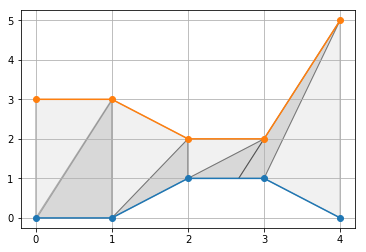

NOT ok 	 The expected value is 1.8639, but the output value is 1.8639610306789278.

[test1]negative.txt	1.0309 1e-05
Hello


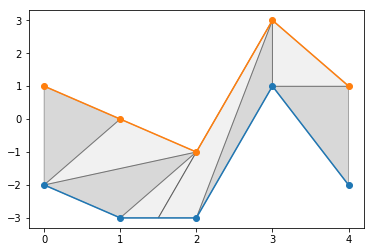

NOT ok 	 The expected value is 1.0309, but the output value is 1.030970684301985.

[test2]simple2.txt	3.9033 1e-05
Hello


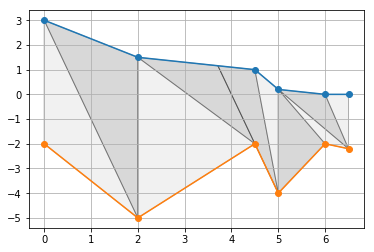

NOT ok 	 The expected value is 3.9033, but the output value is 3.903384142392091.

[test3]intersection.txt	3.5442 1e-05
Hello


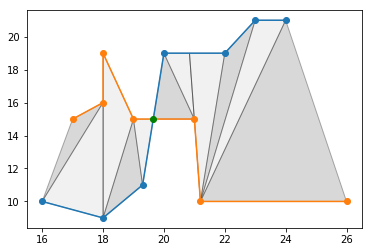

NOT ok 	 The expected value is 3.5442, but the output value is 3.5442607013702894.

[test4]poor_sided.txt	2.8333 1e-05
Hello


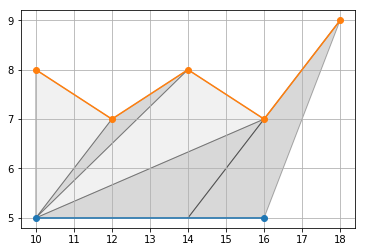

NOT ok 	 The expected value is 2.8333, but the output value is 2.8333333333333335.

[test6].txt	0.8122 1e-05
Hello


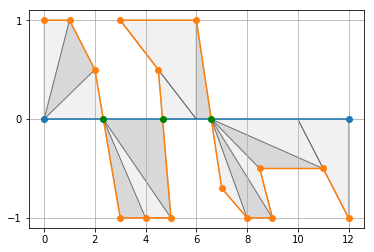

NOT ok 	 The expected value is 0.8122, but the output value is 0.8122140522875817.

[test7].txt	2.0329 1e-05
Hello


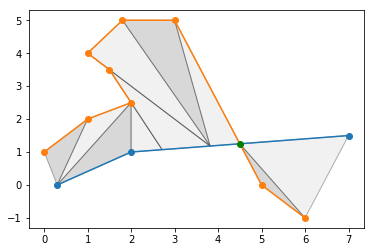

NOT ok 	 The expected value is 2.0329, but the output value is 2.0329426449815213.



False

In [30]:
validator.test(error_btw_trajectories, samples_range = slice(0, None), dirname="../indoor-location-oracles/Oracles/")